<a href="https://colab.research.google.com/github/altink7/Visual-Analytics/blob/main/visual_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Analytics Group Real Estate

## Project Info

Group: **Real estate**

Team Members: **Altin Kelmendi, Julian Hoffmann, Daniel Dodmasej, Clemens Hohensinner**




## Laden der Trainingsdaten
Bevor wir mit der Analyse beginnen, laden wir die Daten in ein Pandas DataFrame. Die Dateien befinden sich im Verzeichnis /content/data/

> Dev: Achtung, wir speichern die Daten nur Temporär im Verzeichnis ( Free Version ), bitte ein fodler data erstellen udn die 4 notwendigen Files dort reingeben. ( wenn der Folder leer ist, bitte diesen befüllen)

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Dateipfade
train_path = "/content/data/train.csv"
test_path = "/content/data/test.csv"
description_path = "/content/data/data_description.txt"

# Lesen der Dateien
# TODO: mount drive or use buckets to store this files and make available for all
df = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Anzeigen von Basisinformationen (Als Sicherung)
df.info()
df.head()

# Fehlende Infos, zu berücksichtigen!
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("---------")
print("Missing Values:\n", missing_values)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Einlesen der Datenbeschreibung

Da die Spaltennamen oft kryptisch sind, nutzen wir eine separate Datei (die teil von Datasets ist), die Erklärungen für die Features enthält.
( Spalten Id zur Bezeichnung)

> Im grunde mappen wir mit der Funktion code zu der vollen Beschreibung für die Labels.

In [18]:
def load_feature_descriptions(filepath):
    descriptions = {}
    with open(filepath, "r") as file:
        for line in file:
            match = re.match(r"(\S+):\s*(.+)", line.strip())  # Match "ColumnName: Description"
            if match:
                column, description = match.groups()
                descriptions[column] = description
    return descriptions

feature_descriptions = load_feature_descriptions(description_path)

# Test Ausgabe vom Map
for key, value in list(feature_descriptions.items())[:5]:
    print(f"{key}: {value}")

def get_feature_label(feature):
    """Returns the human-readable label from the feature_descriptions dictionary.
       Defaults to the original feature name if no description is found.
    """
    return feature_descriptions.get(feature, feature)

MSSubClass: Identifies the type of dwelling involved in the sale.
MSZoning: Identifies the general zoning classification of the sale.
LotFrontage: Linear feet of street connected to property
LotArea: Lot size in square feet
Street: Type of road access to property


# Graphen

Der folgende Bereich enthält einfach die initial ausgewählten Graphen mit einer Beschreibung, wieso wir genau diese ausgewählt haben, und wieso, welche features und mappings ausgewählt wurden

In [19]:
# common styling
# TODO: refine
sns.set_style("whitegrid")

## Distribution of Sale Price
Die Verteilung des Verkaufspreises zeigt, wie die Verkaufspreise der Häuser in deinem Datensatz verteilt sind. Diese Verteilung hilft, die Häufigkeit bestimmter Preisbereiche zu verstehen und mögliche Ausreißer oder Schiefe zu identifizieren. Der KDE (Kernel Density Estimate) ermöglicht eine glatte Darstellung der Verteilung und zeigt, wie die Werte über den Preisbereich verteilt sind.

---

Ein Histogramm mit KDE hilft, die Verteilung von kontinuierlichen Variablen wie dem Verkaufspreis zu untersuchen. Der KDE glättet die Balken des Histogramms und gibt eine bessere Vorstellung von der Verteilung.

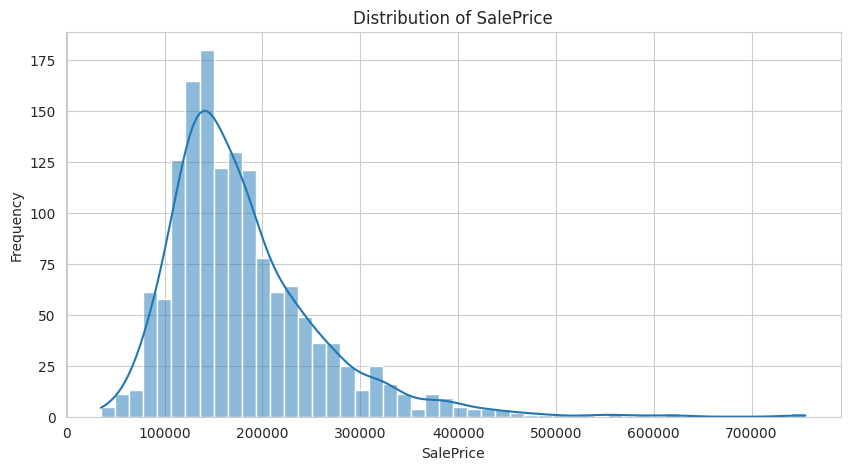

In [29]:
plt.figure(figsize=(10, 5))
sns.histplot(df['SalePrice'], bins=50, kde=True)
plt.title(f"Distribution of {get_feature_label('SalePrice')}")
plt.xlabel(get_feature_label("SalePrice"))
plt.ylabel("Frequency")
plt.show()


## Correlation Heatmap (Top 10 Features)
Die Korrelationsmatrix zeigt, wie stark verschiedene Features miteinander korrelieren. Dies ist besonders nützlich, um herauszufinden, welche Features am stärksten mit dem Zielwert (hier SalePrice) zusammenhängen. Die Heatmap visualisiert diese Korrelationen und hebt die stärksten Zusammenhänge hervor.

---
Korrelationsmatrizen sind hilfreich, um redundante Features zu erkennen (d.h. Features, die stark miteinander korrelieren) und sich auf die wichtigsten Merkmale zu konzentrieren. Wir betrachten nur die Top 10 Features mit der stärksten Korrelation zum Verkaufspreis.

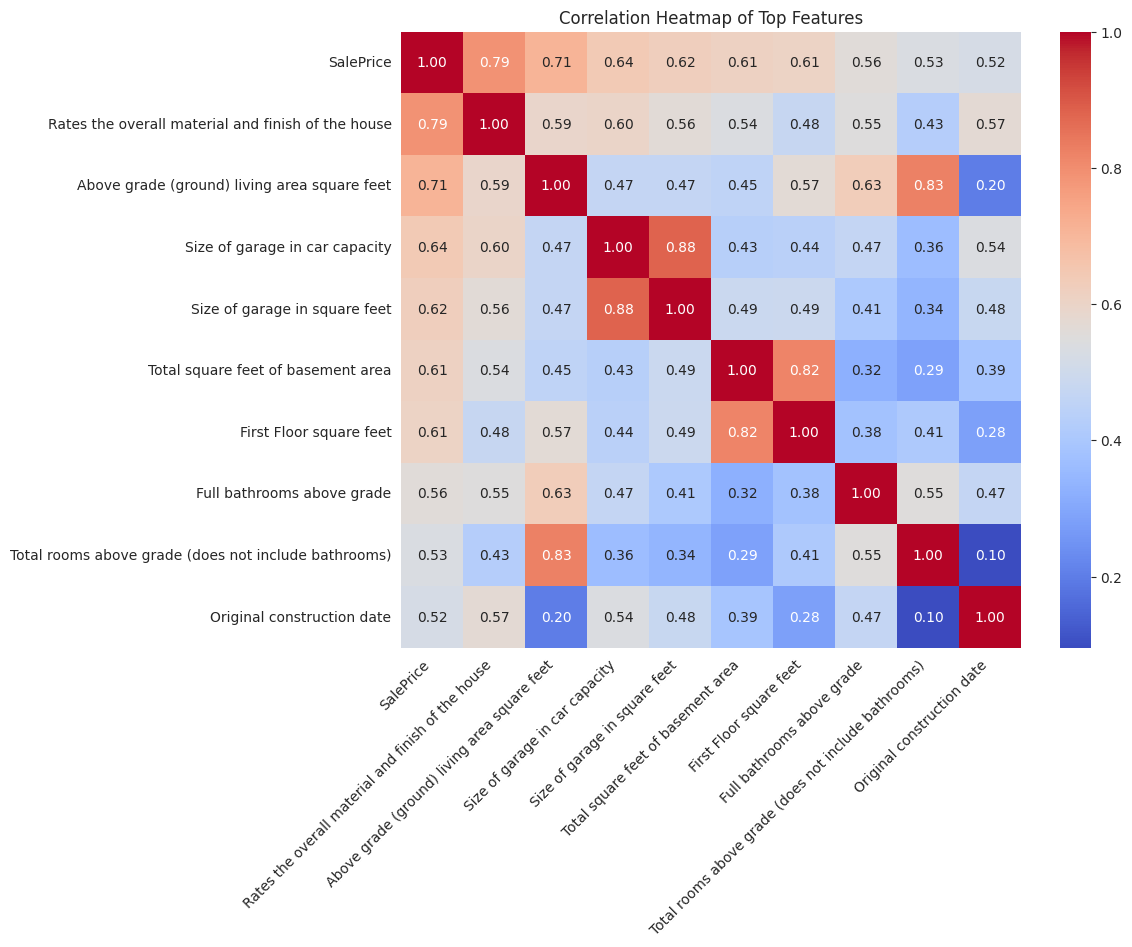

In [21]:
numeric_df = df.select_dtypes(include=np.number)  # Select only numeric features
corr = numeric_df.corr()
top_corr_features = corr['SalePrice'].abs().sort_values(ascending=False).index[:10]

plt.figure(figsize=(10, 8))
sns.heatmap(df[top_corr_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Top Features")
plt.xticks(
    ticks=np.arange(len(top_corr_features)) + 0.5,
    labels=[get_feature_label(col) for col in top_corr_features],
    rotation=45,
    ha="right"
)
plt.yticks(
    ticks=np.arange(len(top_corr_features)) + 0.5,
    labels=[get_feature_label(col) for col in top_corr_features],
    rotation=0
)
plt.show()


## Boxplot: SalePrice vs. OverallQual
Der Boxplot zeigt die Beziehung zwischen der Gesamtqualität eines Hauses (OverallQual) und seinem Verkaufspreis (SalePrice). Der Boxplot gibt Auskunft über die Verteilung und die Ausreißer des Verkaufspreises für unterschiedliche Qualitätskategorien.

---

Ein Boxplot ist ideal, um zu sehen, wie sich die Verteilung des Verkaufspreises in verschiedenen Kategorien (hier OverallQual) unterscheidet und welche Qualitätsstufen die größten Preisschwankungen haben.

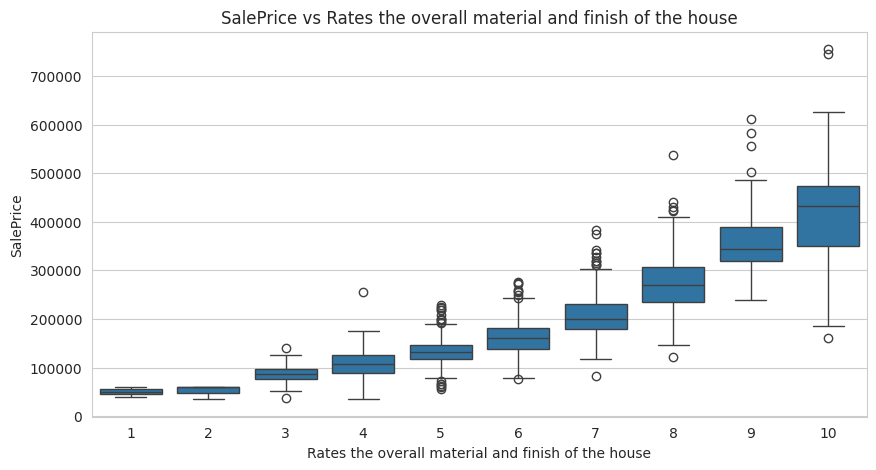

In [22]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["OverallQual"], y=df["SalePrice"])
plt.title(f"{get_feature_label('SalePrice')} vs {get_feature_label('OverallQual')}")
plt.xlabel(get_feature_label("OverallQual"))
plt.ylabel(get_feature_label("SalePrice"))
plt.show()

##  Scatterplot: SalePrice vs. GrLivArea

Das Scatterplot visualisiert den Zusammenhang zwischen der Wohnfläche über dem Boden (GrLivArea) und dem Verkaufspreis (SalePrice). Es zeigt, wie der Verkaufspreis mit zunehmender Fläche steigt, und lässt uns die Verteilung sowie Ausreißer erkennen.

---

Scatterplots sind nützlich, um lineare oder nicht-lineare Beziehungen zwischen zwei kontinuierlichen Variablen zu erkennen. Hier zeigt der Graph, ob größere Häuser höhere Preise erzielen.

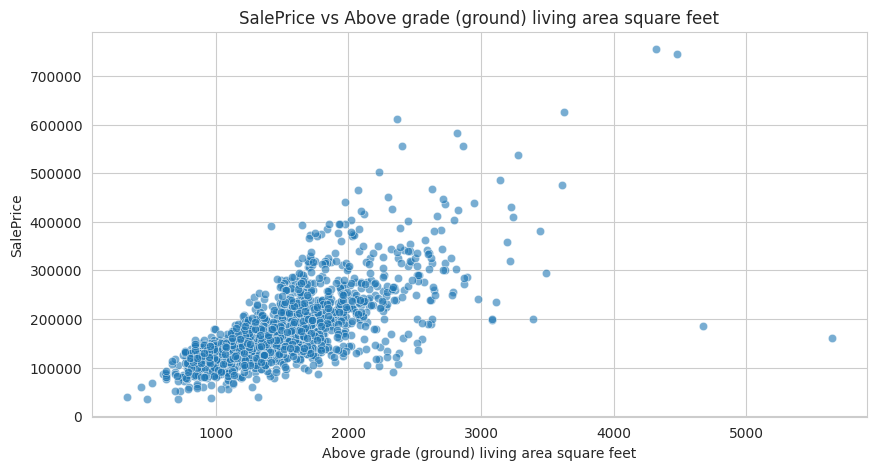

In [23]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df["GrLivArea"], y=df["SalePrice"], alpha=0.6)
plt.title(f"{get_feature_label('SalePrice')} vs {get_feature_label('GrLivArea')}")
plt.xlabel(get_feature_label("GrLivArea"))
plt.ylabel(get_feature_label("SalePrice"))
plt.show()

## Countplot: Neighborhood Distribution
Der Countplot zeigt die Verteilung der verschiedenen Nachbarschaften (Neighborhood) im Datensatz und zählt, wie viele Häuser in jeder Nachbarschaft verkauft wurden. Dies gibt uns einen Überblick darüber, welche Nachbarschaften am häufigsten vertreten sind.

----

Ein Countplot ist ideal, um kategoriale Daten (wie die Nachbarschaftsbezeichnung) zu visualisieren. Er zeigt, welche Kategorien (hier Nachbarschaften) am häufigsten vorkommen und ermöglicht es, Trends oder Verzerrungen in den Daten zu erkennen.

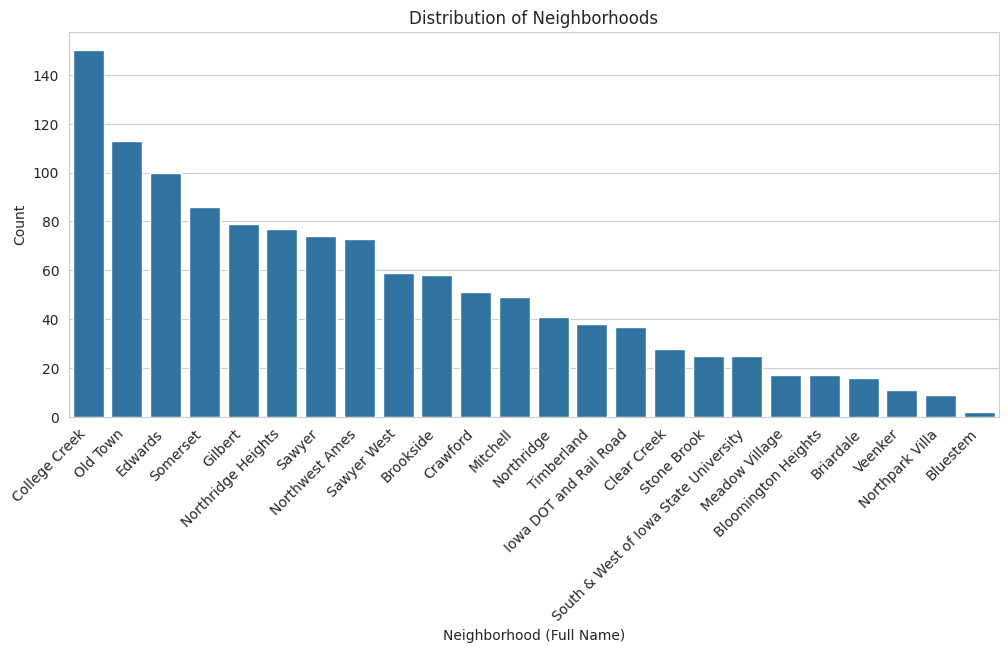

In [24]:
# TODO: fix data_description to retrieve also neighborhood data labels :) -> for right now manual mapping is okay ...
neighborhood_mapping = {
    "Blmngtn": "Bloomington Heights",
    "Blueste": "Bluestem",
    "BrDale": "Briardale",
    "BrkSide": "Brookside",
    "ClearCr": "Clear Creek",
    "CollgCr": "College Creek",
    "Crawfor": "Crawford",
    "Edwards": "Edwards",
    "Gilbert": "Gilbert",
    "IDOTRR": "Iowa DOT and Rail Road",
    "MeadowV": "Meadow Village",
    "Mitchel": "Mitchell",
    "Names": "North Ames",
    "NoRidge": "Northridge",
    "NPkVill": "Northpark Villa",
    "NridgHt": "Northridge Heights",
    "NWAmes": "Northwest Ames",
    "OldTown": "Old Town",
    "SWISU": "South & West of Iowa State University",
    "Sawyer": "Sawyer",
    "SawyerW": "Sawyer West",
    "Somerst": "Somerset",
    "StoneBr": "Stone Brook",
    "Timber": "Timberland",
    "Veenker": "Veenker"
}

df["Neighborhood_Full"] = df["Neighborhood"].map(neighborhood_mapping)

plt.figure(figsize=(12, 5))
sns.countplot(
    x="Neighborhood_Full",
    data=df,
    order=df["Neighborhood_Full"].value_counts().index
)
plt.title("Distribution of Neighborhoods")
plt.xlabel("Neighborhood (Full Name)")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()

# In Class Exercises

Dieser Bereich enthält Aufgaben , die während der Stunde gemacht werden, bitte einklappen.

## Exercise 1: Classification and evaluation

> Please answer for each of the visualizations the following questions in a few bullet points:
> a) Which visualization type is used
> b) How would you judge the visualization according the following criteria, and why:
>- adequacy of chosen visualization type
>- adequacy of mappings from data to visual attributes
   > c) What would you change/improve?

### Example 1

- a: Bar Chart
- b: die mappings attribute sind richtig, aber die werte sind nicht passend, eventuell prozentuelle verteilung ( weil es
  schaut wie ein großer unterschied aus)
- c: Prozentuelle verteilung, und eventuell als Trend anzeigen eine Linoie in dem Fall

### Example 2

- a: Bubble Chart
- b: es ist unübersichtlich, aber barchart wäre besser, weil es einfacher zu lesen ist, mit eventuell 2 achsen (
  einkommen und budget und einnahmen)
- c: Bar Chart, bessere Farben ...

### Example 3

- a: Pie Chart
- b: Die Diemnsionen sind falsch gewählt, man müsste die anzahl der features sehen könenn und diese auch gegenüber
  stellen können
- c: Bar Chart wäre am idealsten x - Achse : Version, und y -Achse anzahl der Features

### Example 4

- a: Trendlines
- b: Dimensionen nicht richtig eingeteil man sieht nue anfang und ende , man sollte es aufteilen in mehrere
  dimensionen um mehr infos zu sehen ( z.b. nach jahren)
- c: Histogram mit jahren in x achse die jahren und y achse die anzahl der starts und mehehrere balken auf einander
  gestapelt

### Example 5

- a: Bar chart
- b: Dimensionen nicht richtig dargestellt 1 ud 39 prozent schauen fast gleich aus
- c: Pie Chart wäre besser, da würde man die prozentuale verteilung besser sehen
-

### Example 6

- a: Histogram
- b: Sehr unübersichtlich, unklare darstellung, keine Beschriftung, Mapping ist aber eventuell richtig nur die
  aufbrechung nicht richtig
- c: 2 varianten : zusammenfassen in einer kategorie zb in jahren für besser darstellung oder trendline über einen
  passenden, oder scatter plot mit zeit und preis

### Example 7

- a: 3d Bubble Chart
- b: Sehr unübersichtlich
- ...

#### Visual Concepts

Data:
– Day: Date format, daily
– Branch #: nominal data
– Branch city: nominal data
– Sales figures, quantitative, continuous

Questions:

- Development over time for specific Branches ?
- Are there branches with specifically good/bad development over the year?

Best Fitting Visualizations:

Question 1: Development over time for specific Branches?

- Line Chart: x-axis: Date, y-axis: Sales figures, color: Branch #, facet: Branch city
- Scatter Plot: x-axis: Date, y-axis: Sales figures, color: Branch #, facet: Branch city

Question 2: Are there branches with specifically good/bad development over the year?

- Bar Chart: x-axis: Branch city, y-axis: Total sales figures, color: Branch #
- Heatmap: x-axis: Date, y-axis: Branch city, color: Sales figures

---
Advantages:
**Notes**:

- The line chart is a good choice for showing the development over time for specific branches.
- The scatter plot is also a good choice for this question, but it is less common and might be harder to read for some
  users.
- The bar chart is a good choice for showing the total sales figures for each branch city.
- The heatmap is a good choice for showing the sales figures over time for each branch city.


